# Day 2

Today, we will start using nf-core pipelines to find differentially abundant genes in our dataset. 
We are using data from the following paper: https://www.nature.com/articles/s41593-023-01350-3#Sec10

1. Please take some time to read through the paper and understand their approach, hypotheses and goals.

What was the objective of the study?

In [ ]:
To understand how chronic neuropathic pain affects the behavioral and transcriptomic responses to oxycodone withdrawal, and to test if inhibiting HDAC1/HDAC2 could alleviate withdrawal symptoms.

What do the conditions mean?

oxy: mice treated with oxycodone, the opioid


sal: control mice treated with saline

What do the genotypes mean?

SNI: refers to mice with a spared nerve injury, which models chronic neuropathic pain


Sham: control mice that underwent a mock surgery without nerve injury

Imagine you are the bioinformatician in the group who conducted this study. They hand you the raw files and ask you to analyze them.

What would you do? I would do a typical RNA seq analysis, with QC, Alignment, Differential Expression Analysis, then functional  enrichment, and then compare different groups.

Which groups would you compare to each other? SNI-Sal vs Sham-Sal, Sham-Oxy vs Sham-Sal,

Please also mention which outcome you would expect to see from each comparison.
SNI-Sal vs Sham-Sal: would expect to see many many DEGs associated with neuroinflammation, stress response etc
Sham-Oxy vs Sham-Sal: should directly reveal the pathways and DEGs involved in withdrawal.

Your group gave you a very suboptimal excel sheet (conditions_runs_oxy_project.xlsx) to get the information you need for each run they uploaded to the SRA.<br>
So, instead of directly diving into downloading the data and starting the analysis, you first need to sort the lazy table.<br>
Use Python and Pandas to get the table into a more sensible order.<br>
Then, perform some overview analysis and plot the results
1. How many samples do you have per condition?
2. How many samples do you have per genotype?
3. How often do you have each condition per genotype?

File loaded successfully!
DataFrame shape: (16, 8)

Original DataFrame:
   Patient          Run RNA-seq  DNA-seq condition: Sal Condition: Oxy  \
0        ?  SRR23195505       x      NaN              x            NaN   
1        ?  SRR23195506       x      NaN            NaN              x   
2        ?  SRR23195507       x      NaN              x            NaN   
3        ?  SRR23195508       x      NaN            NaN              x   
4        ?  SRR23195509       x      NaN            NaN              x   
5        ?  SRR23195510       x      NaN              x            NaN   
6        ?  SRR23195511       x      NaN            NaN              x   
7        ?  SRR23195512       x      NaN              x            NaN   
8        ?  SRR23195513       x      NaN              x            NaN   
9        ?  SRR23195514       x      NaN            NaN              x   
10       ?  SRR23195515       x      NaN              x            NaN   
11       ?  SRR23195516       x      NaN

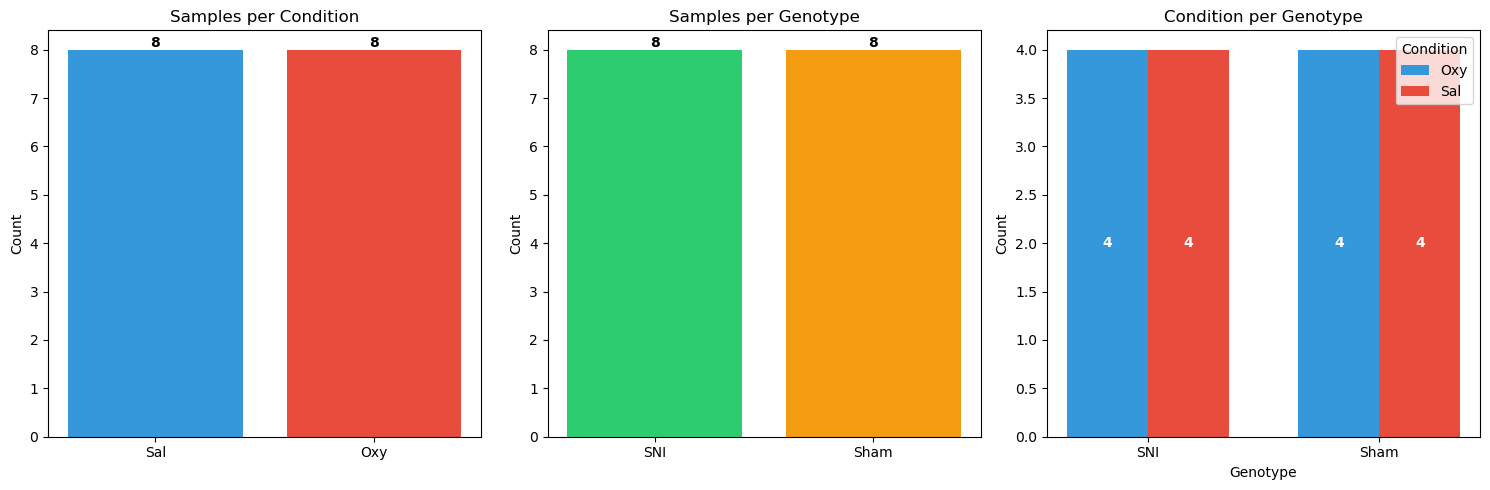


TOTAL SAMPLES: 16
GROUP COUNTS:
  SNI + Sal: 4
  SNI + Oxy: 4
  Sham + Sal: 4
  Sham + Oxy: 4

BALANCED DESIGN: True


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
file_path = "/home/mj/nf-pipelines/computational-workflows-2025/notebooks/day_02/conditions_runs_oxy_project.xlsx"

try:
    df = pd.read_excel(file_path)
    print("File loaded successfully!")
    print(f"DataFrame shape: {df.shape}")
    print("\nOriginal DataFrame:")
    print(df)
    print("\n" + "="*50 + "\n")
except Exception as e:
    print(f"Error loading file: {e}")


# Create tidy dataframe
tidy_data = []
for _, row in df.iterrows():
    run = row['Run']
    
    if row['condition: Sal'] == 'x':
        condition = 'Sal'
    else:
        condition = 'Oxy'
    
    if row['Genotype: SNI'] == 'x':
        genotype = 'SNI'
    else:
        genotype = 'Sham'
    
    tidy_data.append({'Run': run, 'Condition': condition, 'Genotype': genotype})

tidy_df = pd.DataFrame(tidy_data)

# Analysis
condition_counts = tidy_df['Condition'].value_counts()
genotype_counts = tidy_df['Genotype'].value_counts()
condition_genotype_ct = pd.crosstab(tidy_df['Condition'], tidy_df['Genotype'])

print("SAMPLES PER CONDITION:")
print(condition_counts)
print("\nSAMPLES PER GENOTYPE:")
print(genotype_counts)
print("\nCONDITION PER GENOTYPE:")
print(condition_genotype_ct)

# Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Condition counts
colors_cond = ['#3498db', '#e74c3c']
bars1 = axes[0].bar(condition_counts.index, condition_counts.values, color=colors_cond)
axes[0].set_title('Samples per Condition')
axes[0].set_ylabel('Count')
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', 
                ha='center', va='bottom', fontweight='bold')

# Plot 2: Genotype counts
colors_geno = ['#2ecc71', '#f39c12']
bars2 = axes[1].bar(genotype_counts.index, genotype_counts.values, color=colors_geno)
axes[1].set_title('Samples per Genotype')
axes[1].set_ylabel('Count')
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', 
                ha='center', va='bottom', fontweight='bold')

# Plot 3: Condition per genotype
conditions = condition_genotype_ct.index.tolist()
genotypes = condition_genotype_ct.columns.tolist()
x = np.arange(len(genotypes))
width = 0.35

for i, condition in enumerate(conditions):
    values = [condition_genotype_ct.loc[condition, geno] for geno in genotypes]
    axes[2].bar(x + i*width, values, width, label=condition, color=colors_cond[i])

axes[2].set_title('Condition per Genotype')
axes[2].set_ylabel('Count')
axes[2].set_xlabel('Genotype')
axes[2].set_xticks(x + width/2)
axes[2].set_xticklabels(genotypes)
axes[2].legend(title='Condition')

for i, genotype in enumerate(genotypes):
    for j, condition in enumerate(conditions):
        value = condition_genotype_ct.loc[condition, genotype]
        axes[2].text(i + j*width, value/2, f'{value}', 
                    ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print(f"\nTOTAL SAMPLES: {len(tidy_df)}")
print("GROUP COUNTS:")
print(f"  SNI + Sal: {len(tidy_df[(tidy_df['Genotype']=='SNI') & (tidy_df['Condition']=='Sal')])}")
print(f"  SNI + Oxy: {len(tidy_df[(tidy_df['Genotype']=='SNI') & (tidy_df['Condition']=='Oxy')])}")
print(f"  Sham + Sal: {len(tidy_df[(tidy_df['Genotype']=='Sham') & (tidy_df['Condition']=='Sal')])}")
print(f"  Sham + Oxy: {len(tidy_df[(tidy_df['Genotype']=='Sham') & (tidy_df['Condition']=='Oxy')])}")

balanced = len(set(condition_genotype_ct.values.flatten())) == 1
print(f"\nBALANCED DESIGN: {balanced}")


They were so kind to also provide you with the information of the number of bases per run, so that you can know how much space the data will take on your Cluster.<br>
Add a new column to your fancy table with this information (base_counts.csv) and sort your dataframe according to this information and the condition.

Then select the 2 smallest runs from your dataset and download them from SRA (maybe an nf-core pipeline can help here?...) SRR23195516, SRR23195511

In [14]:
import pandas as pd

# Load the data
file_path = "/home/mj/nf-pipelines/computational-workflows-2025/notebooks/day_02/base_counts.csv"

# Load base counts
base_df = pd.read_csv(file_path)

# Merge with tidy dataframe
tidy_df = pd.merge(tidy_df, base_df, on='Run')

# Sort by bases and condition
tidy_df_sorted = tidy_df.sort_values(['Bases', 'Condition'])

print("DATA WITH BASE COUNTS (sorted):")
print(tidy_df_sorted.to_string(index=False))

# Get 2 smallest runs
smallest_runs = tidy_df_sorted.head(2)
print(f"\n2 SMALLEST RUNS TO DOWNLOAD:")
print(smallest_runs[['Run', 'Bases', 'Condition', 'Genotype']].to_string(index=False))

# Save sorted dataframe
tidy_df_sorted.to_csv('sorted_samples_with_bases.csv', index=False)
print(f"\nSorted data saved to 'sorted_samples_with_bases.csv'")

DATA WITH BASE COUNTS (sorted):
        Run Condition Genotype      Bases
SRR23195516       Oxy      SNI 6203117700
SRR23195511       Oxy     Sham 6456390900
SRR23195517       Oxy      SNI 6863840400
SRR23195505       Sal      SNI 6922564500
SRR23195508       Oxy      SNI 6927786900
SRR23195519       Oxy     Sham 6996050100
SRR23195509       Oxy      SNI 7003550100
SRR23195514       Oxy     Sham 7226808600
SRR23195510       Sal      SNI 7377388500
SRR23195512       Sal     Sham 7462857900
SRR23195520       Sal     Sham 7858146000
SRR23195506       Oxy     Sham 7859530800
SRR23195518       Sal      SNI 7908500400
SRR23195507       Sal     Sham 8063298900
SRR23195513       Sal      SNI 8099181600
SRR23195515       Sal     Sham 8169101700

2 SMALLEST RUNS TO DOWNLOAD:
        Run      Bases Condition Genotype
SRR23195516 6203117700       Oxy      SNI
SRR23195511 6456390900       Oxy     Sham

Sorted data saved to 'sorted_samples_with_bases.csv'


In [33]:
!nextflow pull nf-core/fetchngs

Checking nf-core/fetchngs ...
 downloaded from https://github.com/nf-core/fetchngs.git - revision: 8ec2d934f9 [master]


In [34]:
# Create the input file with your two run IDs
with open('ids.csv', 'w') as f:
    f.write('SRR23195516\nSRR23195511\n')

!cat ids.csv

SRR23195516
SRR23195511


While your files are downloading, get back to the paper and explain how you would try to reproduce the analysis.<br>
When you are done with this shout, so we can discuss the different ideas.

In [38]:
# Run the download
!nextflow run nf-core/fetchngs \
    -profile conda \
    --input ids.csv \
    --outdir downloaded_data \
    --max_memory '5GB' \
    -r 1.12.0


 N E X T F L O W   ~  version 25.04.7

Launching `https://github.com/nf-core/fetchngs` [mad_monod] DSL2 - revision: 8ec2d934f9 [1.12.0]

WARN: Access to undefined parameter `monochromeLogs` -- Initialise it to a default value eg. `params.monochromeLogs = some_value`


------------------------------------------------------
                                        ,--./,-.
        ___     __   __   __   ___     /,-._.--~'
  |\ | |__  __ /  ` /  \ |__) |__         }  {
  | \| |       \__, \__/ |  \ |___     \`-._,-`-,
                                        `._,._,'
  nf-core/fetchngs v1.12.0-g8ec2d93
------------------------------------------------------
Core Nextflow options
  revision   : 1.12.0
  runName    : mad_monod
  launchDir  : /home/mj/nf-pipelines/computational-workflows-2025/notebooks/day_02
  workDir    : /home/mj/nf-pipelines/computational-workflows-2025/notebooks/day_02/work
  projectDir : /home/mj/.nextflow/assets/nf-core/fetchngs
  userName   : mj
  profile    : conda
  